## Label switching and it's discontents

As you may recall, I've been trying to get the probit stick-breaking process working so that we can have arbitrary numbers of topics in the model at once alongside predictors that influence topic weights. However, one major problem with this version of the stick-breaking process is that you have to infer the *orders* of the topics as well as the weights -- as in, which topic was the first topic to be "broken off" of the stick, which was the second, etc. Unfortunately, this topic ordering isn't something that we can trivially ignore, either, because it affects inference over the parameters governing the stick-breaking process -- which in this case, include things like demographic and genetic covariates. In other words, the main things we care about!

So, we need our MCMC sampling method to be able to move easily between different possible orderings of the topics. First, I'll demonstrate that the "default" method does not do this. Second, I'll modify the sampling algorithm to include specific "label-switching" steps as found in [this](http://biomet.oxfordjournals.org/content/95/1/169.refs) paper. Third, I will note that these label switching moves totally fuck up the posterior distribution! Fourth I will waste several days trying to figure out what is going on. Fifth, I will give up and we will all move on with our lives.

First, let's simulate some data from a stick-breaking process with 20 components and 500 data points.

In [1]:
using Distributions,Gadfly,StatsFuns,InplaceOps,DataFrames,Cairo,Fontconfig
include("/home/seth/code/sparse_normal_categorical/normal_probit_gibbs.jl");

In [3]:
K=20;
mu=1.5;
sig=1;
n=500;

Below, I simulate many different data sets of the same size and plot the number of different components actually observed in each of those simulated data sets. This give us the prior distribution over the number of groups.

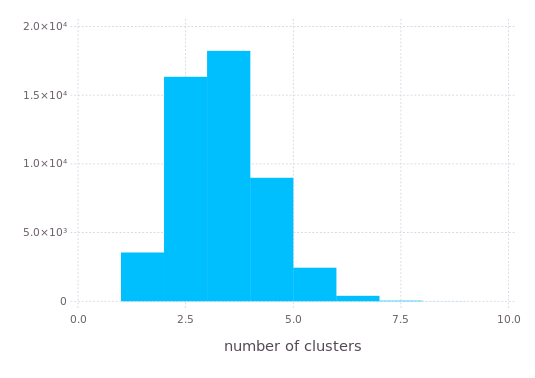

In [46]:
iter = 50000;
x = Array{Int}(iter);
for i in 1:iter
    alpha = randn(K-1)*sig + mu;
    p = a2p(alpha);
    x[i] = countnz(rand(Multinomial(n,p)));
end
plot(x=x,Geom.histogram,Guide.xlabel("number of clusters"))

Next, below I simulate a specific data set that we will run the sampler on...

In [10]:
alpha = randn(K-1)*sig + mu;
p = a2p(alpha);
G0 = Normal(0,5);
G = rand(G0,K);

In [11]:
y = Array{Float64}(n);
z = Array{Int64}(n);
for i in 1:n
    z[i] = findfirst(rand(Multinomial(1,p)));
    y[i] = rand(Normal(G[z[i]],1));
end

In [12]:
unique(z)

3-element Array{Int64,1}:
 1
 2
 3

The output immediately above tells us that their are in truth 3 different components (out of a max of 20) present in the data we just simulated.

Below I define a bunch of functions I need for the sampler...

In [14]:
function lln(y::Float64,mu::Float64)
    -0.5 * (y-mu)^2 / 1.0;
end

function sample_normal(y::Array{Float64},z::Array{Int64},prior)
    K = prior[:K];
    ns = zeros(Float64,K);
    nz = zeros(Int64,K);
    n = length(z);
    theta = Array(Float64,K);

    for i in 1:n
        k = z[i];
        ns[k] += y[i];
        nz[k] += 1;
    end

    for k in 1:K        
        tau = inv( inv(prior[:sigma0]^2) + nz[k]/1.0 );
        mu = tau * (prior[:mu0]/prior[:sigma0]^2 + ns[k]/1.0);
        theta[k] = randn()*sqrt(tau) + mu;
    end
    return theta
end;

In [13]:
prior = Dict{Symbol,Union{Int64,Float64,Array{Float64}}}(
:K=>K,:mu0=>0.0,:sigma0=>5,:muAlpha=>mu,:sigmaAlpha=>sig,:theta_dim=>(1),:nls=>0);

Aaaand... release the sampler!

In [98]:
@time out = psbpm(y,lln,sample_normal,prior,0,1,20000);

 34.910476 seconds (1.28 G allocations: 26.592 GB, 5.31% gc time)


Now let's look at the evolution of the number of components inferred in the data over time...

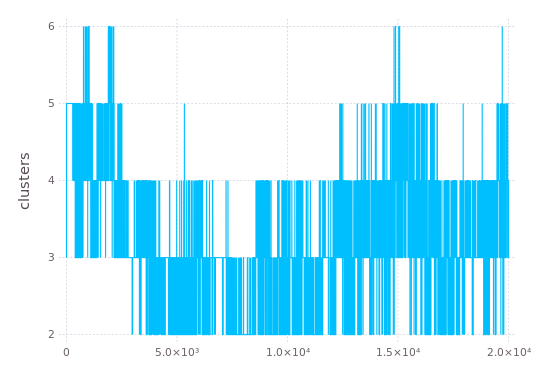

In [99]:
nz = mapslices(x -> length(unique(x)),out[:z],1);
plot(y=nz,Geom.line,Guide.ylabel("clusters"))

Jesus christ that is disgusting. That is not a hairy caterpillar, is a a caterpillar with leprosy and it must be killed for the good of the colony.

### Introducing label-switching

So the generic sampler mixes horribly. But what happens if we introduce sampling steps that explcitly allow the order of components to swap? That might help. Below I allow 10 such steps in every iteration of the sampler, and run the sampler again.

In [61]:
prior[:nls] = 10;
@time out = psbpm(y,lln,sample_normal,prior,0,1,10000);

 15.798528 seconds (640.87 M allocations: 14.226 GB, 5.83% gc time)


Again examining the number of unique components inferred in each iteration...

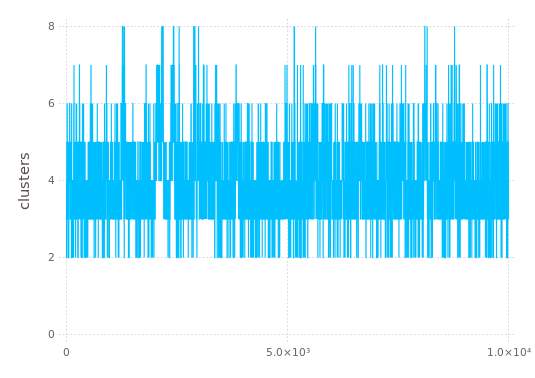

In [62]:
nz = mapslices(x -> length(unique(x)),out[:z],1);
plot(y=nz,Geom.line,Guide.ylabel("clusters"))

Mixing is much better!... but the inferred number of components is way higher! It's higher both than the true number of components (3) and the prior over components (the histogram back at the beginning). What gives?

The model seems to be way underestimating the level of sparsity in the data. In this model, that corresponds to *underestimating* the size of the component-specific weights. So is the model underestimating those weights?

To figure this out, we can look at the weight associated with the weight of the very last component. Now, there are *never* any data points assigned to this component, so the posterior should look the same as the prior for this weight. I set the prior to be centered at 1.5. Looking at the distribution of that final component weight below...

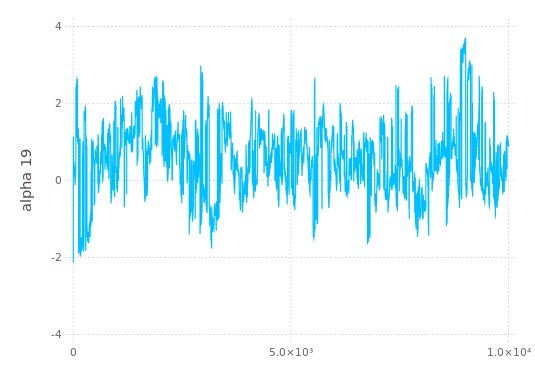

In [102]:
plot(y=out[:alpha][19,:],Geom.line,Guide.ylabel("alpha 19"))

...it seems to want to be much lower than 1.5.

We can see this more clearly if we set the prior mean to be a much larger value and look at the same plot again...

In [100]:
prior[:nls] = 10;
prior[:muAlpha] = 10;
@time out = psbpm(y,lln,sample_normal,prior,0,1,10000);

LoadError: LoadError: InterruptException:
while loading In[100], in expression starting on line 155

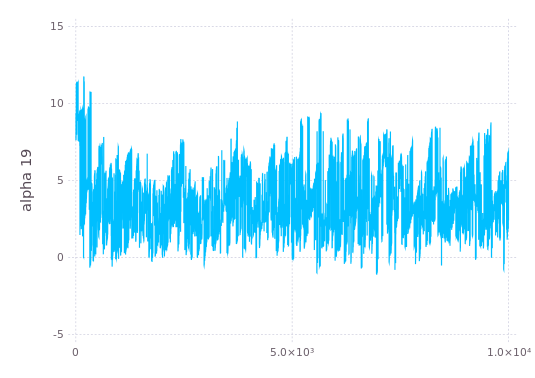

In [74]:
p2 = plot(y=out[:alpha][19,:],Geom.line,Guide.ylabel("alpha 19"))

This should be centered at 10, but instead it's living around 3 or 4. What gives...?

After much deep contemplation, I arrived at the following hypothesis: The first few components in the process have all the data assigned to them, which means their weights are going to be somewhat low (just trust me on this). However, when the label switching moves are accepted, they move those low weights from the first components to the later components. The data points then migrate back up to the first components, but the weights on the later components stay low just because of the slow-moving nature of the gibbs sampler.

If this theory is true, we should be able to see very low weights cascade from the first few compoenents back over time. So let's test this.

In [15]:
prior[:nls] = 1;
prior[:muAlpha] = 10.0;
@time out = psbpm(y,lln,sample_normal,prior,0,1,10000);

 17.936824 seconds (642.21 M allocations: 13.552 GB, 3.96% gc time)


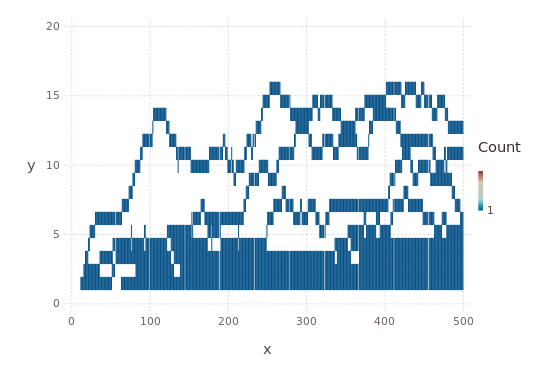

In [16]:
(y,x) = ind2sub(size(out[:alpha]),find(out[:alpha][:,1:500].<7.5));
plot(x=x,y=y,Geom.histogram2d(xbincount=500))

The filled in bits represent components with very low weights, x is time and y is component number. As predicted, there seems to be a a propogation of low values from early components (near 0) to high components (near 20).

## Conclusion

Unfortunately, this knowledge doesn't help a huge amount. The bottom line is, the label switching steps should not have any effect on the posterior of the model, but it is having a huge effect. I can think of ways to avoid the label-switching moves having this effect, but the fact that it's happening at all makes me veeeery nervous and makes me suspicious of their validity in general.

This, combined with numerous other complications involved in analyzing and interpreting the parameters of a stick-breaking process, makes me think that it is not worth the trouble. All we get from the stick-breaking process is the ability to infer the number of components. But we have other (albeit less efficient) ways of doing that. Furthermore, based on these and previous results I've gotten, it's really pretty bad at inferring the number of components! So I'm cutting my losses and moving to a simpler, "non-stick-breaking" foundation for the topic model.